In [186]:
import numpy as np
import json
from collections import defaultdict, Counter
from scipy import spatial, stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import math

In [6]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'
AGG_EMBED_PATH = LOGS + 'semantics_mano/agg_embed/'

## Inspecting individual words

Note that the axes in the wrong direction, e.g. all positive values mean the word leans more towards the opposite of the synset name, while move negative means it is more related to the synset name. This is why "soured" shows up as a prominent positive axis for "sweet girl", etc. 

In [7]:
with open(LOGS + 'semantics_mano/results/scores.json', 'r') as infile: 
    scores = json.load(infile) 

vocab_order = []
with open(LOGS + 'semantics_mano/results/vocab_order.txt', 'r') as infile:
    vocab_order = infile.readlines()

with open(LOGS + 'coref_results/mano_gender_labels.json', 'r') as infile: 
    gender_labels = json.load(infile)

In [8]:
word_poles = defaultdict(Counter) # {word : {pole : score}}
for pole in scores: 
    s = scores[pole]
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        word_poles[term][pole] = s[i]

In [9]:
print(word_poles['alpha'].most_common()[:10])
print(word_poles['alpha'].most_common()[-10:])

[('covered.a.01', 0.25558773434051607), ('clothed.a.01', 0.20460857317052156), ('affected.a.01', 0.19743399192574534), ('busy.a.01', 0.19340250274625598), ('heavy.a.01', 0.1636908153666239), ('mature.a.01', 0.16354657637493), ('androgynous.a.02', 0.15458037457221652), ('delicate.a.01', 0.15350429755099337), ('experienced.a.01', 0.14051773941321305), ('limited.a.01', 0.14049881094011013)]
[('thick.a.01', -0.15037315269704593), ('right.a.04', -0.1534961767732639), ('upland.a.01', -0.15577203865108905), ('capitalistic.a.01', -0.16656310684758813), ('reasonable.a.01', -0.17066723676667722), ('enthusiastic.a.01', -0.17872971894421674), ('optimistic.a.01', -0.182795450552113), ('fat.a.01', -0.2067701379119683), ('moral.a.01', -0.2303085749221428), ('assertive.a.01', -0.26428843033663973)]


In [10]:
print(word_poles['beta'].most_common()[:10])
print(word_poles['beta'].most_common()[-10:])

[('clothed.a.01', 0.2302962468802881), ('busy.a.01', 0.22930095475453216), ('covered.a.01', 0.219025675618927), ('heavy.a.01', 0.20749793146852147), ('experienced.a.01', 0.20338786825387173), ('affected.a.01', 0.18867313060161872), ('active.a.03', 0.17924688026636332), ('visible.a.01', 0.17472462286340498), ('heavy.a.04', 0.16004797618931815), ('stressed.a.02', 0.15305906321978352)]
[('harmless.a.01', -0.1537984253997058), ('auspicious.a.01', -0.15603754767041586), ('quiet.a.02', -0.15667051373894447), ('capitalistic.a.01', -0.15725929069852884), ('defiant.a.01', -0.16001385997621265), ('assertive.a.01', -0.16640615169659442), ('pleasing.a.01', -0.17419947414924292), ('reasonable.a.01', -0.19200510196082082), ('moral.a.01', -0.19343655301123647), ('optimistic.a.01', -0.20350268094208734)]


In [11]:
print(word_poles['escort'].most_common()[:10])
print(word_poles['escort'].most_common()[-10:])

[('visible.a.01', 0.22309017709915227), ('tough.a.01', 0.213360012645474), ('settled.a.02', 0.19296624720667427), ('used.a.01', 0.1857999460473453), ('inclined.a.02', 0.1457751942450308), ('genuine.a.01', 0.144264839289096), ('heavy.a.04', 0.13563279490208444), ('mature.a.01', 0.12739001348117515), ('mindful.a.01', 0.12420469830860567), ('definite.a.01', 0.12353489816582765)]
[('enchanted.a.01', -0.1297488955033736), ('smooth.a.01', -0.13000566120988905), ('serviceable.a.01', -0.1453235611522138), ('east.a.01', -0.15217072046089813), ('assertive.a.01', -0.1561224887165856), ('optimistic.a.01', -0.1587276536999621), ('foreign.a.02', -0.16007725646172424), ('blond.a.01', -0.16609265606499185), ('enthusiastic.a.01', -0.17101999786777775), ('vertical.a.01', -0.1960913578840736)]


In [12]:
print(word_poles['wife'].most_common()[:10])
print(word_poles['wife'].most_common()[-10:])

[('stressed.a.02', 0.1642349879986019), ('communicative.a.02', 0.1548538037300795), ('shod.a.01', 0.1543340554310427), ('inclined.a.02', 0.147667724371479), ('used.a.01', 0.11680373567631179), ('nascent.a.01', 0.11622444489836678), ('practical.a.01', 0.11315294289782041), ('clothed.a.01', 0.11043103649144768), ('androgynous.a.02', 0.1101759594250323), ('worthy.a.01', 0.10829729959320025)]
[('prejudiced.a.02', -0.11483809209471618), ('refined.a.01', -0.11657568793466172), ('rural.a.01', -0.12230937551930993), ('sincere.a.01', -0.1348905506471321), ('enthusiastic.a.01', -0.14627547671047186), ('pleasing.a.01', -0.1476187306605714), ('vertical.a.01', -0.1505769589603431), ('indulgent.a.01', -0.17271745348962464), ('womanly.a.01', -0.2510947708161832), ('blond.a.01', -0.26228053180066013)]


In [13]:
print(word_poles['celebrities'].most_common()[:10])
print(word_poles['celebrities'].most_common()[-10:])

[('tough.a.01', 0.17081688060138467), ('heavy.a.04', 0.16985555976159045), ('shod.a.01', 0.16921350151419515), ('formal.a.01', 0.16257934295405002), ('rational.a.01', 0.1539584724003656), ('clearheaded.a.01', 0.15095418273110356), ('practical.a.01', 0.14949227852479552), ('used.a.01', 0.13713366262867435), ('functional.a.01', 0.13655726047751593), ('live.a.01', 0.13282821636469758)]
[('publicized.a.01', -0.16861678299034474), ('indulgent.a.01', -0.1689884056297398), ('fashionable.a.01', -0.17495802324450085), ('assertive.a.01', -0.1790488263955755), ('blond.a.01', -0.18400036903294198), ('honorable.a.02', -0.19386016991548416), ('capitalistic.a.01', -0.20089025110473818), ('enchanted.a.01', -0.2038839316617339), ('optimistic.a.01', -0.219878418645344), ('enthusiastic.a.01', -0.2702015404193948)]


In [14]:
print(word_poles['princes'].most_common()[:10])
print(word_poles['princes'].most_common()[-10:])

[('tough.a.01', 0.1805231952555273), ('present.a.01', 0.16453077107531805), ('modern.a.01', 0.1598416223346724), ('tough.a.03', 0.1524890905554785), ('used.a.01', 0.1516182763602973), ('surface.a.01', 0.1467284602966408), ('androgynous.a.02', 0.14105737420570597), ('shod.a.01', 0.13003690030581358), ('empirical.a.01', 0.12563998245363733), ('settled.a.02', 0.11645714677201925)]
[('refined.a.01', -0.15650710977105559), ('moral.a.01', -0.1566110449753308), ('glorious.a.01', -0.15852079714472445), ('assertive.a.01', -0.17072084941067336), ('rhetorical.a.02', -0.1747360461794557), ('honorable.a.02', -0.17498177536861484), ('auspicious.a.01', -0.1800081524016834), ('gracious.a.01', -0.190434756294191), ('pleasing.a.01', -0.19060802410015823), ('noble.a.02', -0.43068912052829506)]


In [15]:
print(word_poles['normies'].most_common()[:10])
print(word_poles['normies'].most_common()[-10:])

[('fragrant.a.01', 0.23376121381115872), ('clean.a.01', 0.23125052308491592), ('superior.a.01', 0.22022119417854905), ('educated.a.01', 0.21966800373108855), ('mindful.a.01', 0.2182822500174266), ('busy.a.01', 0.21826220544904631), ('settled.a.02', 0.21495180240785697), ('modest.a.01', 0.21196934804280826), ('careful.a.01', 0.20642503539056628), ('humorous.a.01', 0.20533699336294906)]
[('nonproprietary.a.01', -0.12804204739587602), ('wet.a.01', -0.13109088872897956), ('proud.a.01', -0.14986895208471712), ('moral.a.01', -0.1507341828212458), ('simple.a.01', -0.15215763433495405), ('conscious.a.02', -0.15456060351936168), ('prejudiced.a.02', -0.1595962284843616), ('selfish.a.01', -0.2134563069472661), ('ordinary.a.01', -0.23051900162149913), ('fat.a.01', -0.23554981095825875)]


In [16]:
print(word_poles['simps'].most_common()[:10])
print(word_poles['simps'].most_common()[-10:])

[('clean.a.01', 0.2604844388082124), ('serious.a.01', 0.2527842823082931), ('definite.a.01', 0.24164403889662878), ('conventional.a.04', 0.23772145187427085), ('abstemious.a.01', 0.22977715695462214), ('careful.a.01', 0.216644847990057), ('gracious.a.01', 0.21475233326039692), ('cautious.a.01', 0.21308335759125957), ('tasteful.a.01', 0.2048277942128987), ('busy.a.01', 0.20080071600078564)]
[('cheerful.a.01', -0.13711930530631397), ('flexible.a.02', -0.13992376426055217), ('quiet.a.01', -0.14082034815067648), ('flexible.a.01', -0.1432322652076855), ('nonproprietary.a.01', -0.1515342433042608), ('changeable.a.02', -0.15319182252356459), ('indulgent.a.01', -0.16091865765036034), ('simple.a.01', -0.17922892126620177), ('proud.a.01', -0.216327865672561), ('fat.a.01', -0.281288708181036)]


In [17]:
print(word_poles['prostitute'].most_common()[:10])
print(word_poles['prostitute'].most_common()[-10:])

[('used.a.01', 0.2738366691962819), ('clothed.a.01', 0.23937097872188579), ('settled.a.02', 0.2291109180309099), ('genuine.a.01', 0.20774164855996033), ('reputable.a.01', 0.2034176074242275), ('free.a.01', 0.20046270103216252), ('safe.a.01', 0.19728634455816058), ('superior.a.01', 0.18511084056671884), ('visible.a.01', 0.18354977985627313), ('careful.a.01', 0.1824616231531639)]
[('assertive.a.01', -0.1599361735706449), ('capitalistic.a.01', -0.16414326236623333), ('tired.a.01', -0.17383875787119737), ('optimistic.a.01', -0.17687235032425183), ('commercial.a.01', -0.18044915161152808), ('corrupt.a.01', -0.18965010845156033), ('womanly.a.01', -0.19693576109523947), ('blond.a.01', -0.1993103340935537), ('indulgent.a.01', -0.21088796861255577), ('prejudiced.a.02', -0.26173099058036536)]


In [18]:
print(word_poles['sweet girl'].most_common()[:10])
print(word_poles['sweet girl'].most_common()[-10:])

[('soured.a.01', 0.2993762680324553), ('old.a.01', 0.24585196920696173), ('large.a.01', 0.23454624090201942), ('demanding.a.01', 0.20686306185232417), ('busy.a.01', 0.197643275722586), ('distant.a.02', 0.189853979436521), ('used.a.01', 0.18674327001249796), ('tough.a.03', 0.1843033060276611), ('much.a.01', 0.1842825865919937), ('cursed.a.01', 0.17506098967106104)]
[('reasonable.a.01', -0.20029725604609822), ('sympathetic.a.04', -0.20576029865844586), ('exculpatory.a.01', -0.2085969624311667), ('refined.a.01', -0.22853918654971514), ('beautiful.a.01', -0.23545727870178343), ('sincere.a.01', -0.2519843280077457), ('optimistic.a.01', -0.2563437773193954), ('pleasing.a.01', -0.2725066810670002), ('kind.a.01', -0.2763736927813124), ('lovable.a.01', -0.3158886668571521)]


In [19]:
print(word_poles['thot'].most_common()[:10])
print(word_poles['thot'].most_common()[-10:])

[('definite.a.01', 0.1942506848860781), ('clean.a.01', 0.1673035189706998), ('improved.a.01', 0.16144572589832623), ('motivated.a.01', 0.152628178859815), ('conventional.a.04', 0.14834912226141417), ('assisted.a.01', 0.14402170982564783), ('gracious.a.01', 0.14375817406252167), ('exempt.a.01', 0.1386175631587233), ('meaningful.a.01', 0.1376077435672449), ('stable.a.01', 0.13545902803716559)]
[('strange.a.01', -0.10258656068959875), ('flexible.a.02', -0.10486797902865443), ('satisfactory.a.01', -0.11070000339932176), ('thinkable.a.01', -0.11700241756682321), ('credulous.a.01', -0.12267252067925646), ('fat.a.01', -0.12638101965574716), ('nonproprietary.a.01', -0.12937259858528127), ('old.a.02', -0.13903732562136084), ('same.a.01', -0.15038574864936355), ('distant.a.01', -0.20976531914767527)]


In [20]:
print(word_poles['women'].most_common()[:10])
print(word_poles['women'].most_common()[-10:])

[('stressed.a.02', 0.2689686041765973), ('androgynous.a.02', 0.26615011162215274), ('used.a.01', 0.17418508989923898), ('shod.a.01', 0.17415410665801528), ('heavy.a.04', 0.15623034942651035), ('clothed.a.01', 0.14830480731774676), ('worthy.a.01', 0.14272245389365118), ('resolute.a.01', 0.13329823016528006), ('sacred.a.01', 0.13287332282955855), ('protected.a.01', 0.12342149919623766)]
[('selfish.a.01', -0.12718445486502283), ('capitalistic.a.01', -0.12951324600671643), ('hot.a.03', -0.1325397538418296), ('graceful.a.01', -0.1355055651284687), ('pleasing.a.01', -0.13815785044580048), ('indulgent.a.01', -0.17790987421169782), ('shapely.a.01', -0.18686821149604158), ('prejudiced.a.02', -0.2406379872123752), ('blond.a.01', -0.32147493747143213), ('womanly.a.01', -0.5140653893774207)]


# Variance within gender

In [332]:
fem_variance = Counter() # {pole: variance of fem terms}
fem_extremes = defaultdict(tuple) # {pole: (top N terms, bottom N terms)}
masc_variance = Counter() 
masc_extremes = defaultdict(tuple)
fem_scores = defaultdict(list) # {pole: scores in order of x_words}
masc_scores = defaultdict(list) # {pole: scores in order of y_words}
N = 10
for pole in scores: 
    s = scores[pole]
    x = [] # fem scores
    x_words = []
    y = [] # masc scores
    y_words = []
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        if term in gender_labels: 
            if gender_labels[term] > 0.75: 
                x.append(s[i])
                x_words.append(term)
            elif gender_labels[term] < 0.25: 
                y.append(s[i])
                y_words.append(term)
    fem_variance[pole] = np.var(x)
    indices = np.argpartition(x, -N)[-N:]
    topN = [x_words[idx].strip() for idx in indices]
    indices = np.argpartition(x, N)[:N]
    bottomN = [x_words[idx].strip() for idx in indices]
    fem_extremes[pole] = (topN, bottomN, min(x), max(x))
    fem_scores[pole] = x
    
    masc_variance[pole] = np.var(y)
    indices = np.argpartition(y, -N)[-N:]
    topN = [y_words[idx].strip() for idx in indices]
    indices = np.argpartition(y, N)[:N]
    bottomN = [y_words[idx].strip() for idx in indices]
    masc_extremes[pole] = (topN, bottomN, min(y), max(y))
    masc_scores[pole] = y

In [333]:
for tup in fem_variance.most_common(20): 
    print(tup)
    pole = tup[0]
    topN, bottomN, mi, ma = fem_extremes[pole]
    print("TOP:", topN)
    print("BOTTOM:", bottomN)
    print(mi, ma)
    print()

('womanly.a.01', 0.0207367739111438)
TOP: ['debbie downer', 'creepy stalker', 'harlot', 'fuckbuddy', 'harlots', 'tomboys', 'downer', 'hambeast', 'hambeasts', 'tomboy']
BOTTOM: ['female', 'feminine woman', 'female gender', 'feminine women', 'female feminist', 'women', 'feminist women', 'masculine women', 'women women', 'females']
-0.5856429849438389 0.36751912466938597

('androgynous.a.02', 0.01048472108047411)
TOP: ['1 female', 'black females', 'female', 'white females', 'female gender', 'female one', 'two females', 'females', 'more females', 'female humans']
BOTTOM: ['nympho', 'noodlewhores', 'noodlewhore', 'supermodel', 'supermodels', 'manipulative bitch', 'stepmom', 'harlots', 'harlot', 'tomboy']
-0.19918680740902128 0.4108695695846027

('lovable.a.01', 0.010376138902053338)
TOP: ['female supremacist', 'degenerate whores', 'protester', 'stupid cunts', 'woman hater', 'accusers', 'woman haters', 'false accusers', 'women haters', 'cunts']
BOTTOM: ['cute one', 'cute friend', 'sweet girl

In [334]:
for tup in masc_variance.most_common(20): 
    print(tup)
    pole = tup[0]
    topN, bottomN, mi, ma = masc_extremes[pole]
    print("TOP:", topN)
    print("BOTTOM:", bottomN)
    print(mi, ma)
    print()

('androgynous.a.02', 0.012188110400550777)
TOP: ['male members', 'male character', 'dominant male', 'white males', 'male players', 'one male', 'dominant males', 'masculine male', 'male', 'males']
BOTTOM: ['fucking hypocrites', 'hypocrite', 'fucking hypocrite', 'tenmagnet', 'manipulator', 'hypocrites', 'chiropractor', 'manipulators', 'charlatan', 'endocrinologist']
-0.2604874475023576 0.44170802824635863

('womanly.a.01', 0.01105276724502953)
TOP: ['introvert', 'introverted guy', 'faggots', 'little faggot', 'nutter', 'faggot', 'buffoon', 'goober', 'wimp', 'wanker']
BOTTOM: ['male gender', 'feminist man', 'feminine men', 'feminist leaders', 'male feminist', 'feminist men', 'male feminists', 'masculine male', 'male nurses', 'masculine men']
-0.5029534793157493 0.29910455279596726

('reputable.a.01', 0.009900774126213017)
TOP: ['chump', 'snitch', 'serial rapist', 'schmuck', 'misogynist', 'misogynists', 'mugger', 'muggers', 'wimp', 'wimps']
BOTTOM: ['great leader', 'successful people', 'goo

## Axes similarities for each clusters' highly gendered terms

In [172]:
with open(LOGS + 'gram_counts/combined_catyear_word_count.json', 'r') as infile: 
    catyear_word_count = json.load(infile)
total_vocab_count = Counter() # {term : count in mano reddit + forum}
for catyear in catyear_word_count: 
    for term in catyear_word_count[catyear]: 
        total_vocab_count[term] += catyear_word_count[catyear][term]
# remove bigram counts from unigrams 
for term in total_vocab_count: 
    if ' ' in term: 
        toks = term.split(' ')
        if toks[0] in total_vocab_count: 
            total_vocab_count[toks[0]] = total_vocab_count[toks[0]] - total_vocab_count[term]
        if toks[1] in total_vocab_count: 
            total_vocab_count[toks[1]] = total_vocab_count[toks[1]] - total_vocab_count[term]
print(total_vocab_count.most_common(20))

[('she', 1760546), ('he', 861007), ('women', 801795), ('man', 604788), ('people', 555328), ('girl', 490864), ('woman', 482506), ('someone', 458890), ('guys', 361499), ('guy', 344341), ('men', 336551), ('girls', 326322), ('anyone', 324551), ('friends', 243747), ('everyone', 238800), ('friend', 228233), ('others', 203092), ('female', 178923), ('person', 174827), ('you guys', 167224)]


In [145]:
with open(LOGS + 'time_series/cluster_members_6.json', 'r') as infile: 
    clust_words = json.load(infile)
clust_words_rev = {}
for clust in clust_words: 
    cluster_words = clust_words[clust]
    for w in cluster_words: 
        clust_words_rev[w] = clust

In [348]:
cluster_gender_sum = defaultdict(Counter) # {gender + clust_num : {pole : sum of word scores} }
cluster_gender_total = defaultdict(Counter) # {gender + clust_num : {pole : word count} }
pole_sum = defaultdict(Counter) # {gender : {pole : sum of word scores} }
pole_count = defaultdict(Counter) # {gender : {pole : word count} }
for pole in scores: 
    s = scores[pole]
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        clust_num = clust_words_rev[term]
        if term in gender_labels: 
            if gender_labels[term] > 0.75: 
                cluster_gender_sum[str(clust_num) + '_fem'][pole] += s[i]*total_vocab_count[term]
                cluster_gender_total[str(clust_num) + '_fem'][pole] += total_vocab_count[term]
                pole_sum['fem'][pole] += s[i]*total_vocab_count[term]
                pole_count['fem'][pole] += total_vocab_count[term]
#                 cluster_gender_sum[str(clust_num) + '_fem'][pole] += s[i]
#                 cluster_gender_total[str(clust_num) + '_fem'][pole] += 1
#                 pole_sum['fem'][pole] += s[i]
#                 pole_count['fem'][pole] += 1
            elif gender_labels[term] < 0.25: 
                cluster_gender_sum[str(clust_num) + '_masc'][pole] += s[i]*total_vocab_count[term]
                cluster_gender_total[str(clust_num) + '_masc'][pole] += total_vocab_count[term]
                pole_sum['masc'][pole] += s[i]*total_vocab_count[term]
                pole_count['masc'][pole] += total_vocab_count[term]
#                 cluster_gender_sum[str(clust_num) + '_masc'][pole] += s[i]
#                 cluster_gender_total[str(clust_num) + '_masc'][pole] += 1
#                 pole_sum['masc'][pole] += s[i]
#                 pole_count['masc'][pole] += 1

In [349]:
cluster_gender_avg = defaultdict(Counter) 
cluster_gender_avg_raw = defaultdict(Counter) 
for key in cluster_gender_sum: 
    for pole in cluster_gender_sum[key]: 
        if key.endswith('fem'): 
            pole_avg = pole_sum['fem'][pole] / pole_count['fem'][pole]
        elif key.endswith('masc'): 
            pole_avg = pole_sum['masc'][pole] / pole_count['masc'][pole]
        else: 
            continue
        cluster_gender_avg[key][pole] = cluster_gender_sum[key][pole] / cluster_gender_total[key][pole] - pole_avg
        cluster_gender_avg_raw[key][pole] = cluster_gender_sum[key][pole] / cluster_gender_total[key][pole]

In [350]:
cluster_order = [4, 3, 5, 1, 2, 0]
common_shift_poles = Counter()
for clust_num in cluster_order: 
    for gender in ['fem', 'masc']:
        key = str(clust_num) + '_' + gender
        print(key)
        top = cluster_gender_avg[key].most_common()[:10]
        bottom = cluster_gender_avg[key].most_common()[-10:]
        for tup in top: 
            common_shift_poles[(gender, tup[0])] += 1
        for tup in bottom: 
            common_shift_poles[(gender, tup[0])] += 1
        print(top)
        print(bottom)
        print()

4_fem
[('inclined.a.01', 0.0435827388996584), ('prejudiced.a.02', 0.03490178632892163), ('indulgent.a.01', 0.032401319634501186), ('mobile.a.02', 0.031625384776536945), ('selfish.a.01', 0.03129652244016061), ('trustful.a.01', 0.030442030241389348), ('physical.a.01', 0.030108872245617233), ('credulous.a.01', 0.030080416489881228), ('voluntary.a.01', 0.02914612360646074), ('integrated.a.03', 0.028783549221864914)]
[('stable.a.01', -0.03349944836571742), ('cautious.a.01', -0.03364800400118047), ('androgynous.a.02', -0.03491723557772604), ('employed.a.01', -0.035141655495986746), ('finished.a.01', -0.03610152017685227), ('skilled.a.01', -0.0397415229430746), ('articulate.a.01', -0.04134774130185986), ('concerned.a.01', -0.043918352775362525), ('settled.a.02', -0.043918416077449694), ('educated.a.01', -0.04584284546581627)]

4_masc
[('bright.a.01', 0.02383466668197318), ('common.a.01', 0.023230546540641554), ('delicate.a.01', 0.019749021597258956), ('decisive.a.03', 0.019350300822505984), (

In [351]:
common_shift_poles.most_common()

[(('fem', 'womanly.a.01'), 4),
 (('fem', 'beautiful.a.01'), 4),
 (('fem', 'prejudiced.a.02'), 3),
 (('fem', 'androgynous.a.02'), 3),
 (('masc', 'delicate.a.01'), 3),
 (('masc', 'lawful.a.01'), 3),
 (('masc', 'liked.a.01'), 3),
 (('masc', 'educated.a.01'), 3),
 (('fem', 'conventional.a.04'), 3),
 (('fem', 'lovable.a.01'), 3),
 (('masc', 'conventional.a.04'), 3),
 (('masc', 'heavy.a.04'), 3),
 (('masc', 'beautiful.a.01'), 3),
 (('masc', 'androgynous.a.02'), 3),
 (('fem', 'indulgent.a.01'), 2),
 (('fem', 'selfish.a.01'), 2),
 (('fem', 'physical.a.01'), 2),
 (('fem', 'skilled.a.01'), 2),
 (('fem', 'articulate.a.01'), 2),
 (('fem', 'settled.a.02'), 2),
 (('fem', 'educated.a.01'), 2),
 (('masc', 'decisive.a.03'), 2),
 (('masc', 'natural.a.02'), 2),
 (('masc', 'womanly.a.01'), 2),
 (('masc', 'rich.a.01'), 2),
 (('masc', 'intellectual.a.02'), 2),
 (('masc', 'stressed.a.02'), 2),
 (('masc', 'serious.a.01'), 2),
 (('masc', 'sympathetic.a.04'), 2),
 (('fem', 'old.a.01'), 2),
 (('fem', 'clean.a.01

In [299]:
fem_axes = ['beautiful.a.01', 'lovable.a.01', 'prejudiced.a.02', 'old.a.01', 'clean.a.01']
masc_axes = ['educated.a.01', 'liked.a.01', 'beautiful.a.01', 'heavy.a.04', 'delicate.a.01']

In [300]:
for clust_num in cluster_order: 
    for gender in ['fem', 'masc']:
        key = str(clust_num) + '_' + gender
        if gender == 'fem': 
            this_axes = fem_axes
        if gender == 'masc': 
            this_axes = masc_axes
        for pole in this_axes: 
            print(key, pole, cluster_gender_avg_raw[key][pole])

4_fem beautiful.a.01 -0.04581709614375898
4_fem lovable.a.01 -0.07384939871079269
4_fem prejudiced.a.02 -0.12460909707736825
4_fem old.a.01 0.08516260496604304
4_fem clean.a.01 0.0017531047279941417
4_masc educated.a.01 0.0313209562485265
4_masc liked.a.01 -0.05256445734593639
4_masc beautiful.a.01 -0.02928160053972833
4_masc heavy.a.04 0.12977394376513388
4_masc delicate.a.01 0.10201538008760735
3_fem beautiful.a.01 -0.07709091135741379
3_fem lovable.a.01 -0.10224184974967267
3_fem prejudiced.a.02 -0.16322240086062637
3_fem old.a.01 0.1507855219179773
3_fem clean.a.01 0.0793637577443496
3_masc educated.a.01 0.056379903240881296
3_masc liked.a.01 -0.045167622256890284
3_masc beautiful.a.01 -0.04851101486988881
3_masc heavy.a.04 0.14370499043052443
3_masc delicate.a.01 0.08801177241042711
5_fem beautiful.a.01 0.05497683761918617
5_fem lovable.a.01 0.03966202759496083
5_fem prejudiced.a.02 -0.24678658986116037
5_fem old.a.01 0.06542743186976162
5_fem clean.a.01 0.048851065321657706
5_mas

### New visualization plan

scatter plot for each axis, x-axis is overall frequency of word, y-axis is score, hue is the cluster number

In [301]:
d = {
    'pole': [], 
    'gender': [],
    'clust_num': [], 
    'word': [], 
    'score': [],
    'frequency': [],
}
for clust_num in cluster_order: 
    for gender in ['fem', 'masc']:
        key = str(clust_num) + '_' + gender
        if gender == 'fem': 
            this_axes = fem_axes
        if gender == 'masc': 
            this_axes = masc_axes
        for pole in this_axes:  
            s = scores[pole]
            for i, term in enumerate(vocab_order): 
                term = term.strip()
                if str(clust_words_rev[term]) != str(clust_num): continue
                if term not in gender_labels: continue
                if gender == 'fem' and gender_labels[term] > 0.75: 
                    d['pole'].append(pole)
                    d['gender'].append(gender)
                    d['clust_num'].append(clust_num)
                    d['word'].append(term)
                    d['score'].append(s[i])
                    d['frequency'].append(total_vocab_count[term])
                if gender == 'masc' and gender_labels[term] < 0.25: 
                    d['pole'].append(pole)
                    d['gender'].append(gender)
                    d['clust_num'].append(clust_num)
                    d['word'].append(term)
                    d['score'].append(s[i])
                    d['frequency'].append(total_vocab_count[term])

In [302]:
cluster_score_df = pd.DataFrame.from_dict(d)
cluster_score_df['log_freq'] = cluster_score_df['frequency'].apply(lambda x: math.log10(x))
clust_num_letter_map = {4 : 'A', 3 : 'B', 5 : 'C', 1 : 'D', 2 : 'E', 0 : 'F'}
cluster_score_df['clust_letter'] = cluster_score_df['clust_num'].apply(lambda x: clust_num_letter_map[x])
cluster_score_df

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
0,beautiful.a.01,fem,4,1 female,0.036255,700,2.845098,A
1,beautiful.a.01,fem,4,10 women,-0.002096,2914,3.464490,A
2,beautiful.a.01,fem,4,100 girls,-0.062551,1723,3.236285,A
3,beautiful.a.01,fem,4,15 women,0.029945,426,2.629410,A
4,beautiful.a.01,fem,4,2 women,0.016124,2053,3.312389,A
...,...,...,...,...,...,...,...,...
17930,delicate.a.01,masc,0,virgin men,0.034152,892,2.950365,F
17931,delicate.a.01,masc,0,white chad,0.105987,2223,3.346939,F
17932,delicate.a.01,masc,0,white chads,0.042333,878,2.943495,F
17933,delicate.a.01,masc,0,white incel,-0.105055,580,2.763428,F


In [303]:
cluster_score_df[cluster_score_df['word'] == 'women']

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
9493,beautiful.a.01,fem,1,women,-0.036429,801795,5.904063,D
9838,lovable.a.01,fem,1,women,-0.065459,801795,5.904063,D
10183,prejudiced.a.02,fem,1,women,-0.240638,801795,5.904063,D
10528,old.a.01,fem,1,women,0.084115,801795,5.904063,D
10873,clean.a.01,fem,1,women,-0.002982,801795,5.904063,D


In [305]:
cluster_score_df[cluster_score_df['word'] == 'girls']

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
4403,beautiful.a.01,fem,3,girls,-0.095671,326322,5.513646,B
4722,lovable.a.01,fem,3,girls,-0.130053,326322,5.513646,B
5041,prejudiced.a.02,fem,3,girls,-0.213103,326322,5.513646,B
5360,old.a.01,fem,3,girls,0.242922,326322,5.513646,B
5679,clean.a.01,fem,3,girls,0.061343,326322,5.513646,B


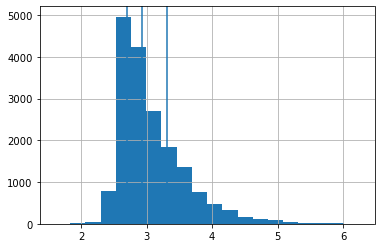

In [279]:
frequencies = cluster_score_df['log_freq'].to_list()
first_cutoff = np.percentile(frequencies, 1/4*100)
second_cutoff = np.percentile(frequencies, 2/4*100)
third_cutoff = np.percentile(frequencies, 3/4*100)
cluster_score_df['log_freq'].hist(bins=20)
plt.axvline(first_cutoff)
plt.axvline(second_cutoff)
plt.axvline(third_cutoff)
plt.show()

In [281]:
def get_freq_bucket(x): 
    if x <= third_cutoff:
        return 'bottom 75%'
    else: 
        return 'top 25%'
cluster_score_df['freq_bucket'] = cluster_score_df['log_freq'].apply(get_freq_bucket)
cluster_score_df

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter,freq_bucket
0,beautiful.a.01,fem,4,1 female,0.036255,700,2.845098,A,bottom 75%
1,beautiful.a.01,fem,4,10 women,-0.002096,2914,3.464490,A,top 25%
2,beautiful.a.01,fem,4,100 girls,-0.062551,1723,3.236285,A,bottom 75%
3,beautiful.a.01,fem,4,15 women,0.029945,426,2.629410,A,bottom 75%
4,beautiful.a.01,fem,4,2 women,0.016124,2053,3.312389,A,bottom 75%
...,...,...,...,...,...,...,...,...,...
17930,delicate.a.01,masc,0,virgin men,0.034152,892,2.950365,F,bottom 75%
17931,delicate.a.01,masc,0,white chad,0.105987,2223,3.346939,F,top 25%
17932,delicate.a.01,masc,0,white chads,0.042333,878,2.943495,F,bottom 75%
17933,delicate.a.01,masc,0,white incel,-0.105055,580,2.763428,F,bottom 75%


In [282]:
fem_cluster_score_df = cluster_score_df[cluster_score_df['gender'] == 'fem']
masc_cluster_score_df = cluster_score_df[cluster_score_df['gender'] == 'masc']

In [325]:
def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return(df)
cluster_order_str = [str(x) for x in cluster_order]
pole_titles = {'beautiful.a.01' : 'beautiful $\longleftrightarrow$ ugly',
               'lovable.a.01' : 'loveable $\longleftrightarrow$ detestable', 
               'prejudiced.a.02': 'prejudiced $\longleftrightarrow$ unprejudiced', 
               'old.a.01': 'old $\longleftrightarrow$ young', 
               'clean.a.01': 'clean $\longleftrightarrow$ dirty', 
               'educated.a.01': 'knowledgeable $\longleftrightarrow$ ignorant',
               'liked.a.01': 'likeable $\longleftrightarrow$ unlikable', 
               'heavy.a.04': 'distressful $\longleftrightarrow$ casual, light', 
               'delicate.a.01': 'delicate $\longleftrightarrow$ tough',
              }

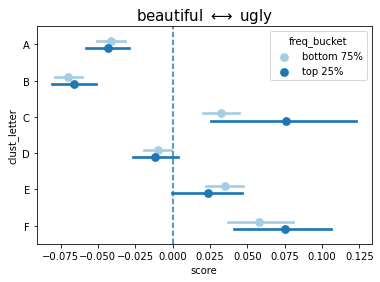

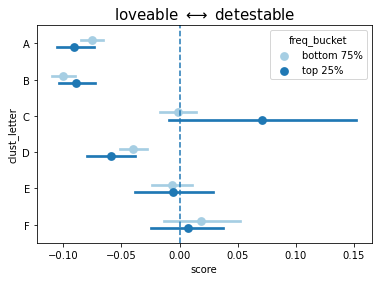

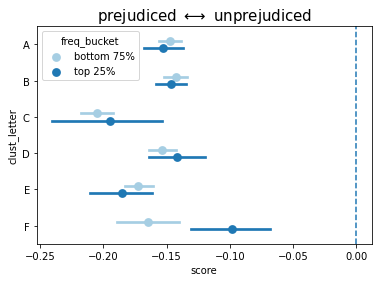

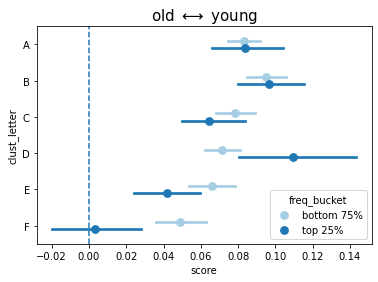

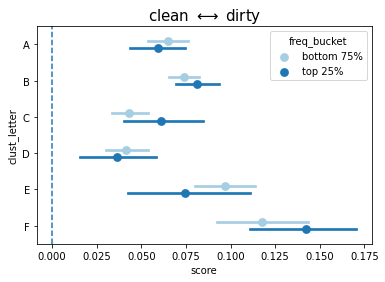

In [343]:
for pole in fem_axes: 
    this_df = fem_cluster_score_df[fem_cluster_score_df['pole'] == pole]
    sns.pointplot(x="score", y="clust_letter", hue='freq_bucket', palette="Paired",
                  data=this_df, orient="h", dodge=.2, join=False)
    plt.axvline(0, linestyle='--')
    plt.title(pole_titles[pole], fontsize=15)
    plt.show()

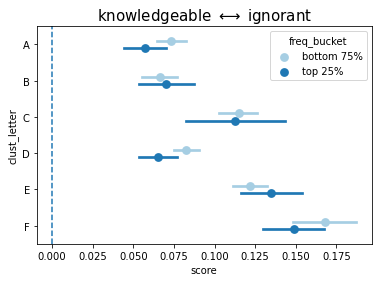

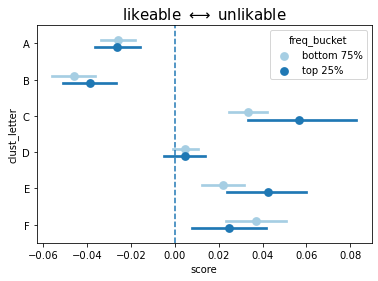

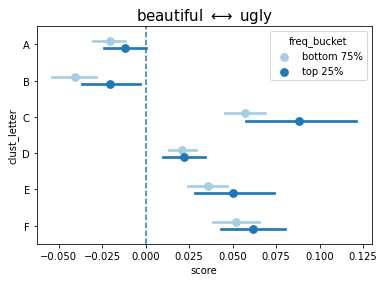

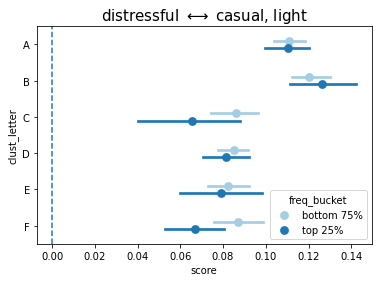

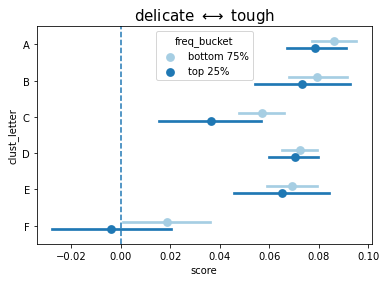

In [342]:
for pole in masc_axes: 
    this_df = masc_cluster_score_df[masc_cluster_score_df['pole'] == pole]
    sns.pointplot(x="score", y="clust_letter", hue='freq_bucket', palette="Paired",
                  data=this_df, orient="h", dodge=.2, join=False)
    plt.axvline(0, linestyle='--')
    plt.title(pole_titles[pole], fontsize=15)
    plt.show()